<a href="https://colab.research.google.com/github/sh3986/kaggle/blob/main/v6_keras_mobilenet_pretrain_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Library

In [2]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:.5f}".format

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

import os
from os import listdir
from os.path import isfile, join
import cv2
from PIL import Image
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Average
from tensorflow.keras import optimizers
tf.__version__

'2.8.2'

In [3]:
# Visualization
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

import skimage.morphology as morp
from skimage.filters import rank
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TensoFlow Version:  2.8.2


In [4]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn"

In [5]:
import os
os.chdir(data_path)

In [6]:
data = []
labels = []

height = 180
width = 180
channels = 3
num_classes = 43

In [ ]:
# for i in range(num_classes) :
#     path = f'./data/Train/{i}/'
#     Class = os.listdir(path)
#     for a in Class:
#         image = cv2.imread(path + a)
#         image_from_array = Image.fromarray(image, 'RGB')
#         size_image = image_from_array.resize((height, width))
#         data.append(np.array(size_image))
#         labels.append(i)

# data = np.array(data)
# labels = np.array(labels)

# import pickle
# with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_data_180.pkl","wb") as f:
#     pickle.dump(data, f)

# with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_label_180.pkl","wb") as f:
#     pickle.dump(labels, f)

### 데이터 로드

In [7]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_data_180.pkl","rb") as f:
    data = pickle.load(f)
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_label_180.pkl","rb") as f:
    labels = pickle.load(f)

In [8]:
print(data.shape)
print(labels.shape)

(26010, 180, 180, 3)
(26010,)


In [ ]:
X = data
y = tf.one_hot(labels, num_classes).numpy()

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Train, Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, shuffle=True, stratify=y)

In [ ]:
# f, ax = plt.subplots(figsize=(10, 5))
# sns.countplot(np.argmax(y_train, axis=1))

### 탐색 분석

In [ ]:
X = data
y = tf.one_hot(labels, num_classes).numpy()

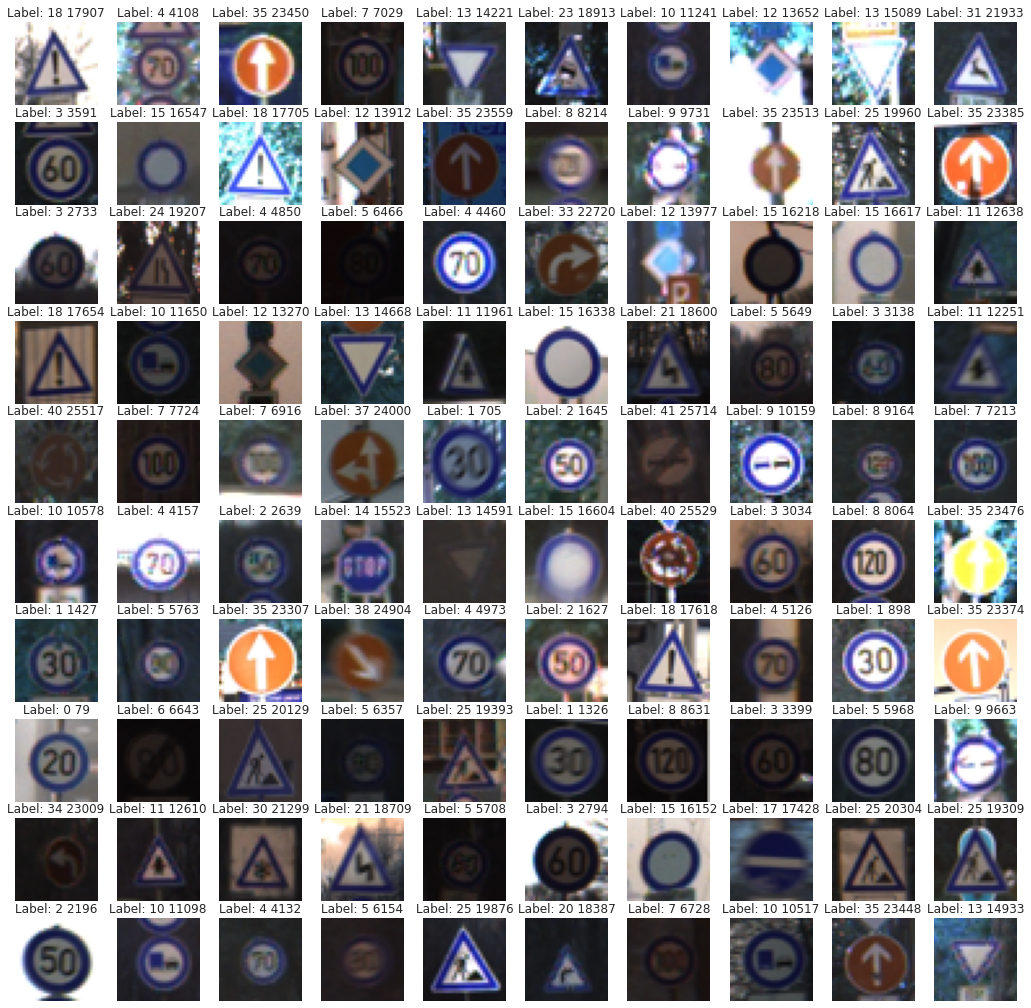

In [ ]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r]))+" "+str(r))

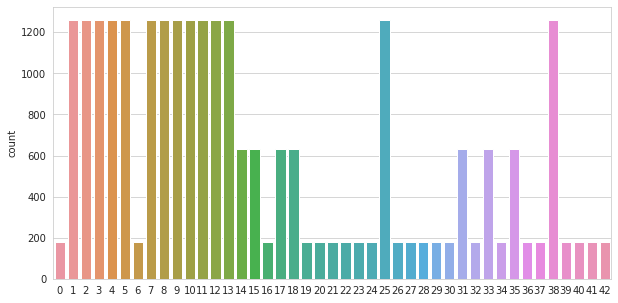

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(labels)

In [ ]:
uni_pattern = np.unique(labels, return_counts=True)
idxs = uni_pattern[0]
ratios = uni_pattern[1]/len(labels)

In [ ]:
def Scaler(data_X,method = 'MinMax'):
  X = data_X.copy()
  X = X.astype(np.float64)

  if method == 'Divide255':
    X = X/255.0

  elif method == 'Standard':
    for a in X:
      for i in range(len(['r','g','b'])):
        mean_ = a[:,:,i].mean()
        std_ = a[:,:,i].std()
        a[:,:,i] = (a[:,:,i] - mean_)/std_

  elif method == 'MinMax':
    for a in X:
      for i in range(len(['r','g','b'])):
        max_ = a[:,:,i].max()
        min_ = a[:,:,i].min()
        a[:,:,i] = (a[:,:,i] - min_)/(max_ - min_)

  elif method == 'MinMax255':
    for a in X:
      for i in range(len(['r','g','b'])):
        max_ = a[:,:,i].max()
        min_ = a[:,:,i].min()
        a[:,:,i] = ((a[:,:,i] - min_)/(max_ - min_))*255
    return np.array(X,dtype='uint8')      

  return X

def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return np.array(image)

def img_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    image_from_array = Image.fromarray(final, 'RGB')
    size_image = image_from_array.resize((height, width))

    return np.array(size_image)

def preprocessing(data_X):
  data = []
  for img in data_X:
    img = img_contrast(to_grayscale_then_rgb(img))
    data.append(img)
  data = np.array(data)

  return data 

def preprocessing_gray(data_X):
  data = []
  for img in data_X:
    img = to_grayscale_then_rgb(img)
    data.append(img)
  data = np.array(data)

  return data 

In [ ]:
X = preprocessing_gray(Scaler(X, 'MinMax255'))

In [ ]:
print(X.shape)
print(y.shape)

(26010, 32, 32, 3)
(26010, 43)


### Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    brightness_range=[0.6, 0.9],
    zoom_range=0.2,
    width_shift_range=0.2,    
    height_shift_range=0.2,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    # rescale=1./255,
)

In [ ]:
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size = 32
) 

valid_generator = valid_datagen.flow(
    X_test, y_test,
    batch_size = 32,
    shuffle=False
)

#### Aug Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

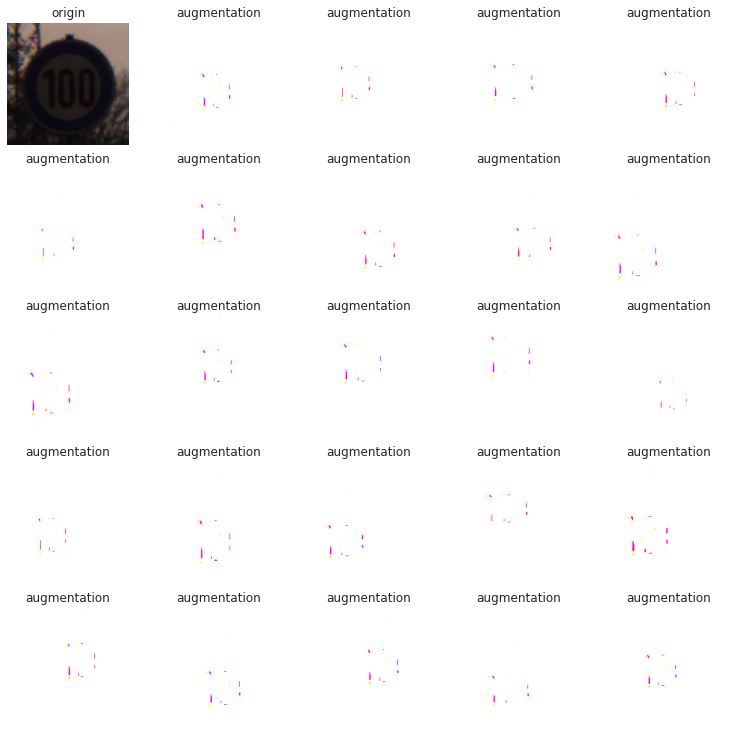

In [ ]:
idx = 6768
input_img = X[idx]
input_label = y[idx]
input_img =  np.array([input_img]) 

generator = train_datagen.flow(input_img, batch_size=1)

f, axes = plt.subplots(5, 5, figsize=(13, 13))
ax_list = axes.flat
ax_list[0].imshow(input_img[0])
ax_list[0].axis('off')
ax_list[0].set_title("origin")

for i, img in enumerate(generator):
    ax_list[i+1].imshow(img[0])
    ax_list[i+1].axis('off')   
    ax_list[i+1].set_title("augmentation")
    if i > 22:
        break

### 모델 생성

In [ ]:
IMG_SHAPE = (height, width, channels)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
# 모델 테스팅
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
train_generator.reset()

(32, 6, 6, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer =  Dense(num_classes, activation= 'softmax')

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

### 모델 학습

In [ ]:
model_check = ModelCheckpoint('./workplace/model/mobilenet_pretrained.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

In [ ]:
n_epochs = 20
history =  model.fit(
    train_generator, 
    batch_size = 32, epochs = n_epochs, verbose = 1, 
    validation_data=valid_generator, 
    callbacks = [model_check, early, reduce_lr]
)

Epoch 1/50
651/651 [==============================] - 165s 249ms/step - loss: 1.1577 - accuracy: 0.6390 - val_loss: 0.6116 - val_accuracy: 0.8080 - lr: 0.0010
Epoch 2/50
651/651 [==============================] - 157s 241ms/step - loss: 0.6113 - accuracy: 0.7949 - val_loss: 0.5030 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 3/50
651/651 [==============================] - 156s 240ms/step - loss: 0.5085 - accuracy: 0.8283 - val_loss: 0.4317 - val_accuracy: 0.8626 - lr: 0.0010
Epoch 4/50
651/651 [==============================] - 156s 240ms/step - loss: 0.4599 - accuracy: 0.8415 - val_loss: 0.4096 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 5/50
651/651 [==============================] - 155s 238ms/step - loss: 0.4259 - accuracy: 0.8514 - val_loss: 0.3862 - val_accuracy: 0.8774 - lr: 0.0010
Epoch 6/50
651/651 [==============================] - 155s 238ms/step - loss: 0.4106 - accuracy: 0.8585 - val_loss: 0.3656 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 7/50
651/651 [==========================

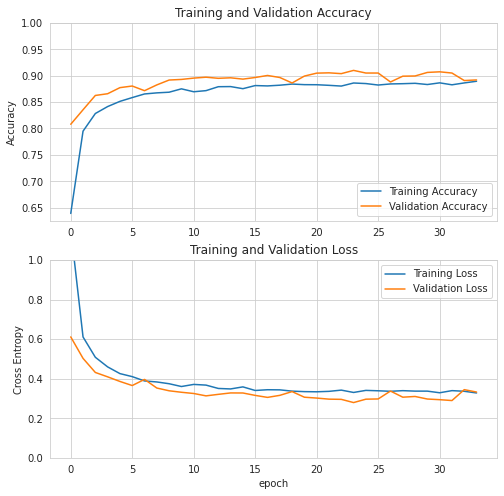

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 모델 Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
len(model.trainable_variables)

56

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_check = ModelCheckpoint('./workplace/model/mobilenet_pretrained_fine_tuning.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [ ]:
fine_tune_epochs = 10
total_epochs =  n_epochs + fine_tune_epochs

history_fine =  model.fit(
    train_generator, 
    batch_size = 32, epochs = total_epochs, verbose = 1, 
    validation_data=valid_generator, 
    callbacks = [model_check, early, reduce_lr]
)

Epoch 1/60
651/651 [==============================] - 167s 251ms/step - loss: 0.3496 - accuracy: 0.8985 - val_loss: 0.0974 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 2/60
651/651 [==============================] - 163s 251ms/step - loss: 0.0793 - accuracy: 0.9772 - val_loss: 0.0823 - val_accuracy: 0.9758 - lr: 0.0010
Epoch 3/60
651/651 [==============================] - 163s 251ms/step - loss: 0.0674 - accuracy: 0.9797 - val_loss: 0.0695 - val_accuracy: 0.9815 - lr: 0.0010
Epoch 4/60
651/651 [==============================] - 161s 247ms/step - loss: 0.0523 - accuracy: 0.9848 - val_loss: 0.0787 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/60
651/651 [==============================] - 160s 246ms/step - loss: 0.0498 - accuracy: 0.9857 - val_loss: 0.0871 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 6/60
651/651 [==============================] - 163s 250ms/step - loss: 0.0296 - accuracy: 0.9913 - val_loss: 0.0553 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 7/60
651/651 [==========================

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

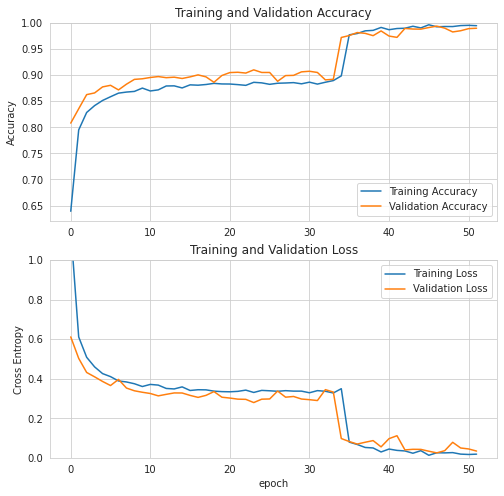

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 모델 성능 평가

In [ ]:
# model_path = './workplace/model/base_line.h5'
# model.load_weights(model_path)

In [ ]:
loss, acc = model.evaluate_generator(valid_generator)
print('Accuracy: ', acc, '\nLoss    : ', loss)

Accuracy:  0.9938485026359558 
Loss    :  0.024905558675527573


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

valid_generator.reset()
y_pred = model.predict_generator(valid_generator)
y_pred = tf.argmax(y_pred, axis=1).numpy()

In [ ]:
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.99      0.98      0.99       252
           2       0.98      0.98      0.98       252
           3       0.99      0.99      0.99       252
           4       1.00      0.99      0.99       252
           5       0.98      0.98      0.98       252
           6       0.97      1.00      0.99        36
           7       0.99      1.00      0.99       252
           8       1.00      1.00      1.00       252
           9       1.00      0.99      1.00       252
          10       1.00      1.00      1.00       252
          11       1.00      1.00      1.00       252
          12       1.00      1.00      1.00       252
          13       1.00      1.00      1.00       252
          14       1.00      0.99      1.00       126
          15       0.98      1.00      0.99       126
          16       1.00      0.97      0.99        36
          17       0.99    

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels=range(43))
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(cm, annot=True,  cmap='Blues')

### Ensemble

In [ ]:
model_baseline = create_model(img_rows,img_cols,img_channels)
model_gray_minmax = create_model(img_rows,img_cols,img_channels)
model_gray_contrast_minmax_over = create_model(img_rows,img_cols,img_channels)

model_baseline.load_weights('./workplace/model/model_no_preprocess_94.h5')
model_gray_minmax.load_weights('./workplace/model/mode_gray_minmax.h5')
model_gray_contrast_minmax_over.load_weights('./workplace/model/model_contrast_gray_oversample_minmax_99.h5')


models = [model_baseline, model_gray_minmax, model_gray_contrast_minmax_over]

In [ ]:
def ensemble(models):
    input = Input(shape=(img_rows,img_cols,img_channels))
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(Average, y, name='ensemble')
    return model

In [ ]:
ensemble_model = ensemble(models)

ValueError: ignored

### 모델 테스트

In [ ]:
from tensorflow import keras 
model = keras.models.load_model(model_name)

### 테스트 데이터 예측

In [ ]:
# test_data = []
# file_name = []
# path = f'./data/Test/'
# Class = os.listdir(path)
# for a in Class:
#     image = cv2.imread(path + a)
#     image_from_array = Image.fromarray(image, 'RGB')
#     size_image = image_from_array.resize((height, width))
#     test_data.append(np.array(size_image))
#     file_name.append(a)

# test_data = np.array(test_data)
# file_name = np.array(file_name)

# import pickle 

# with open('./data/test_data_180.pkl', 'wb') as f:
#     pickle.dump(test_data, f)

# with open('./data/file_name_180.pkl', 'wb') as f:
#     pickle.dump(file_name, f)

In [ ]:
import pickle
with open('./data/test_data_180.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('./data/file_name_180.pkl', 'rb') as f:
    file_name = pickle.load(f)

In [ ]:
test_data.shape

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    test_data,
    batch_size = 32,
    shuffle=False
) 
test_generator.reset()
test_label = model.predict_generator(test_generator)
test_label = tf.argmax(test_label, axis=1).numpy()

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(test_label)

In [ ]:
img_data = [np.array(x) for x in test_data]
img_df = pd.DataFrame({'img':img_data, 'file_name':file_name, 'label':test_label})
debug_data = img_df.sort_values(by=['file_name'])

In [ ]:
def debug_image(debug_data, category, next_file=None):
    filter_data = debug_data[debug_data['label']==category].reset_index()
    if next_file is not None:
        filter_data = filter_data[filter_data['file_name'] > next_file]

    fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize=(18, 23))
    for i, ax in enumerate(axes.flat):
        record = filter_data.iloc[i]
        img = record['img']
        file_name = record['file_name']
        ax.imshow(img)
        ax.set_title(file_name, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show() 

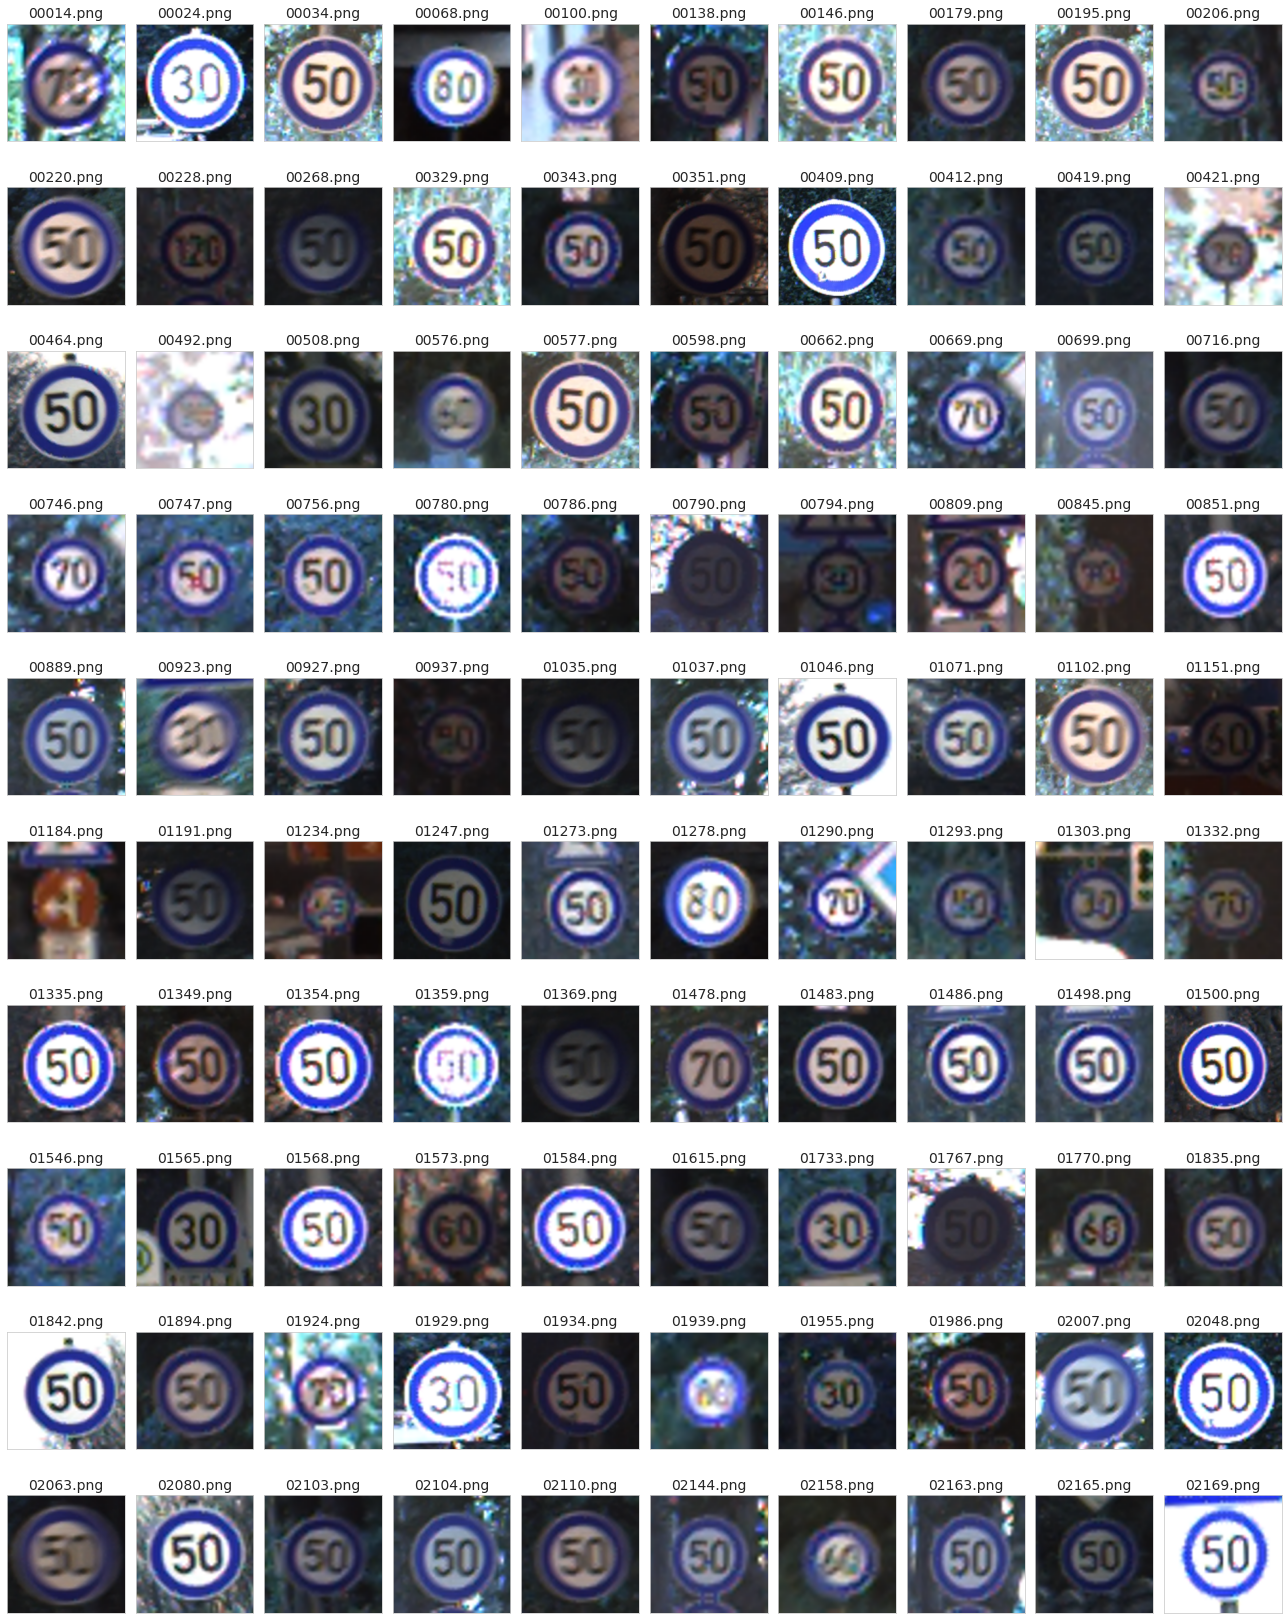

In [ ]:
debug_image(debug_data, 2)

In [ ]:
csv_data = pd.DataFrame(np.concatenate((file_name.reshape(-1, 1), test_label.reshape(-1,1)), axis=1))
csv_data = csv_data.sort_values(by=[0])
csv_data.head()

0   1
279   00000.png  16
8119  00001.png   1
3628  00002.png  38
1565  00003.png  33
5360  00004.png  11

In [ ]:
csv_data.to_csv("predicted_output_v4.csv", header=False, index=False)

In [ ]:
from google.colab import files
files.download("predicted_output_v4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 주석

살짝 로테이션 줘야하나

```python
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

# Prepare data-augmenting data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        preprocessing_function=add_noise,
    )
```

```python
def get_ensemble():
	# define the base models
	models = list()
	# normalization
	norm = Pipeline([('s', MinMaxScaler()), ('m', DecisionTreeClassifier())])
	models.append(('norm', norm))
	# standardization
	std = Pipeline([('s', StandardScaler()), ('m', DecisionTreeClassifier())])
	models.append(('std', std))
	# robust
	robust = Pipeline([('s', RobustScaler()), ('m', DecisionTreeClassifier())])
	models.append(('robust', robust))
	# power
	power = Pipeline([('s', PowerTransformer()), ('m', DecisionTreeClassifier())])
	models.append(('power', power))
	# quantile
	quant = Pipeline([('s', QuantileTransformer(n_quantiles=100, output_distribution='normal')), ('m', DecisionTreeClassifier())])
	models.append(('quant', quant))
	# kbins
	kbins = Pipeline([('s', KBinsDiscretizer(n_bins=20, encode='ordinal')), ('m', DecisionTreeClassifier())])
	models.append(('kbins', kbins))
	# define the voting ensemble
	ensemble = VotingClassifier(estimators=models, voting='hard')
	return ensemble
```
